<a href="https://colab.research.google.com/github/taito-s-0106/ichiyasaGitSample/blob/master/%E3%82%A4%E3%83%99%E3%83%B3%E3%83%88%E3%82%B9%E3%82%BF%E3%83%87%E3%82%A3%E6%B3%95_%E3%83%95%E3%82%A1%E3%83%BC%E3%82%B9%E3%83%88%E3%83%AA%E3%83%86%E3%82%A4%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [665]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ファーストリテイリング（9983.T）の株価データとTOPIXのデータをStooqから取得
ticker_first_retailing = '9983.JP'
ticker_topix = '^TPX'

# 取得期間
start_date = '2024-07-31'
end_date = '2024-11-15'

In [666]:
# Stooqからデータを取得する関数
def get_stooq_data(ticker, start_date, end_date):
    url = f'https://stooq.com/q/d/l/?s={ticker}&d1={start_date.replace("-", "")}&d2={end_date.replace("-", "")}&i=d'
    df = pd.read_csv(url)
    df.columns = df.columns.str.strip()  # 列名の前後の空白を削除
    # Check if 'Date' column exists, if not, try other common names
    if 'Date' not in df.columns:
        if 'date' in df.columns:
            df.rename(columns={'date': 'Date'}, inplace=True)  # Rename 'date' to 'Date'
        else:
            # If no common date column found, raise an error or handle it accordingly
            raise KeyError(f"Date column not found in DataFrame for ticker: {ticker}. Available columns: {df.columns.tolist()}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df


In [667]:
# データ取得
first_retailing_df = get_stooq_data(ticker_first_retailing, start_date, end_date)
topix_df = get_stooq_data(ticker_topix, start_date, end_date)


In [668]:
# データの確認
print(first_retailing_df.head())
print(topix_df.head())

             Open   High    Low  Close   Volume
Date                                           
2024-07-31  40550  42090  40500  41650  1969700
2024-08-01  40980  41100  39790  41100  1992500
2024-08-02  39850  41100  39850  40340  2784800
2024-08-05  39640  40080  35140  36470  3144500
2024-08-06  39210  39660  36710  39320  4001900
               Open     High      Low    Close      Volume
Date                                                      
2024-07-31  2733.28  2799.48  2720.64  2794.26  2326259600
2024-08-01  2767.44  2768.22  2684.91  2703.69  2773892500
2024-08-02  2653.94  2656.63  2536.28  2537.60  3167245800
2024-08-05  2488.25  2489.22  2206.73  2227.15  4326680200
2024-08-06  2271.50  2470.24  2270.93  2434.21  3652526800


In [669]:
# リターンを計算
first_retailing_df['Return'] = first_retailing_df['Close'].pct_change()
topix_df['Return'] = topix_df['Close'].pct_change()

In [670]:
# データを結合
merged_df = first_retailing_df[['Return']].join(topix_df[['Return']], lsuffix='_first', rsuffix='_topix')


In [671]:

# 欠損値を削除
merged_df.dropna(inplace=True)

In [672]:
# データの確認
print(merged_df.head())
print(merged_df.describe())
print(merged_df.isna().sum())


            Return_first  Return_topix
Date                                  
2024-08-01     -0.013205     -0.032413
2024-08-02     -0.018491     -0.061431
2024-08-05     -0.095935     -0.122340
2024-08-06      0.078146      0.092971
2024-08-07     -0.006612      0.022595
       Return_first  Return_topix
count     70.000000     70.000000
mean       0.003003      0.000167
std        0.025429      0.023854
min       -0.095935     -0.122340
25%       -0.008877     -0.006404
50%        0.003214      0.001622
75%        0.016451      0.008604
max        0.078146      0.092971
Return_first    0
Return_topix    0
dtype: int64


In [673]:
# 市場モデルの推定
X = merged_df['Return_topix']
Y = merged_df['Return_first']
X = sm.add_constant(X)

In [674]:
# 定数項を追加

model = sm.OLS(Y, X).fit()

In [675]:
# 推定結果を表示
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Return_first   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     101.7
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           3.86e-15
Time:                        13:21:12   Log-Likelihood:                 190.22
No. Observations:                  70   AIC:                            -376.4
Df Residuals:                      68   BIC:                            -371.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0029      0.002      1.478   

In [676]:
# イベントスタディの実施
event_date = '2024-10-31'  # 仮のイベント日
event_window = 10  # イベントウィンドウ（前後10営業日）

event_start = pd.to_datetime(event_date) - pd.Timedelta(days=event_window)
event_end = pd.to_datetime(event_date) + pd.Timedelta(days=event_window)

event_data = merged_df.loc[event_start:event_end]



In [677]:
# イベントウィンドウ内のデータ確認
print(event_data.head())
print(event_data.describe())
print(event_data.isna().sum())

            Return_first  Return_topix
Date                                  
2024-10-21     -0.008400     -0.003373
2024-10-22     -0.031815     -0.010612
2024-10-23     -0.016722     -0.005472
2024-10-24     -0.007317     -0.000527
2024-10-25     -0.006972     -0.006545
       Return_first  Return_topix
count     13.000000     13.000000
mean      -0.006311      0.003025
std        0.017125      0.009112
min       -0.032969     -0.010612
25%       -0.016722     -0.003373
50%       -0.007317     -0.000339
75%        0.002181      0.009120
max        0.025458      0.019390
Return_first    0
Return_topix    0
dtype: int64


In [678]:
# 異常リターンの計算
event_data['Predicted_Return'] = model.predict(sm.add_constant(event_data['Return_topix']))
event_data['Abnormal_Return'] = event_data['Return_first'] - event_data['Predicted_Return']

<ipython-input-678-4cc811945d0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data['Predicted_Return'] = model.predict(sm.add_constant(event_data['Return_topix']))
<ipython-input-678-4cc811945d0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data['Abnormal_Return'] = event_data['Return_first'] - event_data['Predicted_Return']


In [679]:
# 異常リターンの累積和を計算（累積異常リターン）
event_data['CAR'] = event_data['Abnormal_Return'].cumsum()

<ipython-input-679-01f55fa07e3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data['CAR'] = event_data['Abnormal_Return'].cumsum()


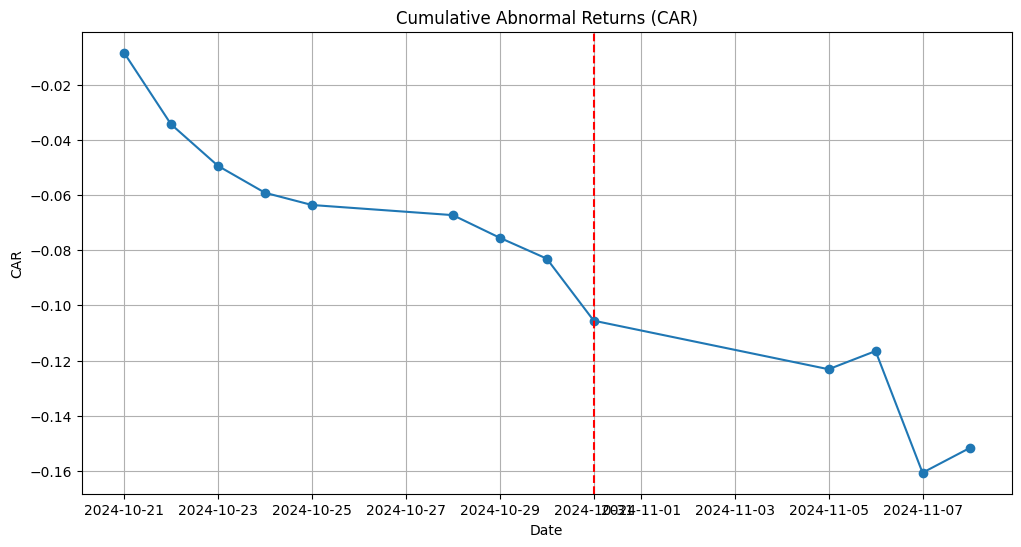

In [680]:
# 結果をプロット
plt.figure(figsize=(12, 6))
plt.plot(event_data.index, event_data['CAR'], marker='o')
plt.axvline(pd.to_datetime(event_date), color='r', linestyle='--')
plt.title('Cumulative Abnormal Returns (CAR)')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.grid(True)
plt.show()

In [681]:
import numpy as np
from scipy import stats

In [682]:
# 異常リターンの計算（前提として event_data['Abnormal_Return'] が存在する）
abnormal_returns = event_data['Abnormal_Return']


In [683]:
# 異常リターンの平均と標準誤差を計算
mean_ar = np.mean(abnormal_returns)
std_ar = np.std(abnormal_returns, ddof=1)
se_ar = std_ar / np.sqrt(len(abnormal_returns))


In [684]:
# t値を計算
t_value = mean_ar / se_ar


In [685]:
# 有意水準5%でのt検定
alpha = 0.05
df = len(abnormal_returns) - 1  # 自由度
t_critical = stats.t.ppf(1 - alpha/2, df)

In [686]:
# 結果を表示
print(f"t値: {t_value}")
print(f"臨界値: {t_critical}")

t値: -3.0177592612495117
臨界値: 2.1788128296634177


In [687]:
if abs(t_value) > t_critical:
    print("異常リターンは有意です。")
else:
    print("異常リターンは有意ではありません。")


異常リターンは有意です。


In [688]:
# 移動ウィンドウの設定
window_size = 5  # 5日間の移動ウィンドウ
alpha = 0.05  # 有意水準


In [689]:
# 移動ウィンドウ内の異常リターンの有意性を検定（イベント発生日を含む）
def moving_window_t_test_post_event(abnormal_returns, event_index, window_size, alpha):
    significant_periods = []
    for i in range(event_index, len(abnormal_returns) - window_size + 1):
        window_ar = abnormal_returns[i:i + window_size]
        mean_ar = np.mean(window_ar)
        std_ar = np.std(window_ar, ddof=1)
        se_ar = std_ar / np.sqrt(window_size)
        t_value = mean_ar / se_ar
        df = window_size - 1
        t_critical = stats.t.ppf(1 - alpha/2, df)
        if abs(t_value) > t_critical:
            significant_periods.append((i, i + window_size - 1))
    return significant_periods

In [690]:
# 異常リターンの計算（前提として event_data['Abnormal_Return'] が存在する）
abnormal_returns = event_data['Abnormal_Return'].values


In [691]:
event_index = event_data.index.get_loc(event_date)

In [692]:
# イベント発生日を含む有意な期間を特定
significant_periods_post_event = moving_window_t_test_post_event(abnormal_returns, event_index, window_size, alpha)

In [693]:
# 有意な期間を全て出力
if significant_periods_post_event:
    print("有意な期間（イベント発生後）:")
    for start, end in significant_periods_post_event:
        start_date_post_event = event_data.index[start]
        end_date_post_event = event_data.index[end]
        print(f"開始日: {start_date_post_event}, 終了日: {end_date_post_event}")
else:
    print("有意な期間（イベント発生後）は見つかりませんでした。")

有意な期間（イベント発生後）は見つかりませんでした。
